This example shows how to perform GP regression, but using **variational inference** rather than exact inference. There are a few cases where variational inference may be prefereable:

1) If you have lots of data, and want to perform **stochastic optimization**

2) If you have a model where you want to use other variational distributions

KISS-GP with SVI was introduced in:
https://papers.nips.cc/paper/6426-stochastic-variational-deep-kernel-learning.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Create a training set
# We're going to learn a sine function
train_x = torch.linspace(0, 1, 1000)
train_y = torch.sin(train_x * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2

## Performing SGD - the dataloader

Because we want to do stochastic optimization, we have to put the dataset in a pytorch **DataLoader**.
This creates easy minibatches of the data

In [3]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## The model

This is pretty similar to a normal regression model, except now we're using a `gpytorch.models.GridInducingVariationalGP` instead of a `gpytorch.models.ExactGP`.

Any of the variational models would work. We're using the `GridInducingVariationalGP` because we have many data points, but only 1 dimensional data.

Similar to exact regression, we use a `GaussianLikelihood`.

In [4]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.random_variables import GaussianRandomVariable

class GPRegressionModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPRegressionModel, self).__init__(grid_size=20, grid_bounds=[(-0.05, 1.05)])
        self.mean_module = ConstantMean(prior=SmoothedBoxPrior(-10, 10))
        self.covar_module = RBFKernel(
            log_lengthscale_prior=SmoothedBoxPrior(math.exp(-3), math.exp(6), sigma=0.1, log_transform=True)
        )
        self.register_parameter(
            name="log_outputscale",
            parameter=torch.nn.Parameter(torch.Tensor([0])),
            prior=SmoothedBoxPrior(math.exp(-5), math.exp(1), sigma=0.1, log_transform=True),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x) * self.log_outputscale.exp()
        return GaussianRandomVariable(mean_x, covar_x)
    
model = GPRegressionModel()
likelihood = gpytorch.likelihoods.GaussianLikelihood()

## The training loop

This training loop will use **stochastic optimization** rather than batch optimization

In [5]:
model.train()
likelihood.train()

# We'll do 40 iterations of optimization
n_iter = 40

# We use SGD here, rather than Adam
# Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.SGD([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# We use a Learning rate scheduler from PyTorch to lower the learning rate during optimization
# We're going to drop the learning rate by 1/10 after 3/4 of training
# This helps the model converge to a minimum
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.75 * n_iter], gamma=0.1)

# Our loss object
# We're using the VariationalMarginalLogLikelihood object
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, n_data=train_y.size(0))

# The training loop
def train():
    for i in range(n_iter):
        scheduler.step()
        
        # Within each iteration, we will go over each minibatch of data
        for x_batch, y_batch in train_loader:
            x_batch = torch.autograd.Variable(x_batch.float())
            y_batch = torch.autograd.Variable(y_batch.float())
            optimizer.zero_grad()
            
            # We're going to use two context managers here
            
            # The use_toeplitz flag makes learning faster on the GPU
            # See the DKL-MNIST notebook for an explanation
            
            # The diagonal_correction flag improves the approximations we're making for variational inference
            # It makes running time a bit slower, but improves the optimization and predictions
            with gpytorch.settings.use_toeplitz(False), gpytorch.beta_features.diagonal_correction():
                output = model(x_batch)
                loss = -mll(output, y_batch)
                print('Iter %d/%d - Loss: %.3f (%.3f)' % (i + 1, n_iter, loss.data[0], optimizer.param_groups[0]['lr']))
            
            # The actual optimization step
            loss.backward()
            optimizer.step()
            
%time train()

/home/jrg365/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter 1/40 - Loss: 20.399 (0.100)
Iter 1/40 - Loss: 18.651 (0.100)
Iter 1/40 - Loss: 17.317 (0.100)
Iter 1/40 - Loss: 16.199 (0.100)
Iter 1/40 - Loss: 15.267 (0.100)
Iter 1/40 - Loss: 14.627 (0.100)
Iter 1/40 - Loss: 13.976 (0.100)
Iter 1/40 - Loss: 13.521 (0.100)
Iter 1/40 - Loss: 13.101 (0.100)
Iter 1/40 - Loss: 12.819 (0.100)
Iter 1/40 - Loss: 12.504 (0.100)
Iter 1/40 - Loss: 12.258 (0.100)
Iter 1/40 - Loss: 12.232 (0.100)
Iter 1/40 - Loss: 12.020 (0.100)
Iter 1/40 - Loss: 11.863 (0.100)
Iter 1/40 - Loss: 11.756 (0.100)
Iter 2/40 - Loss: 11.702 (0.100)
Iter 2/40 - Loss: 11.655 (0.100)
Iter 2/40 - Loss: 11.561 (0.100)
Iter 2/40 - Loss: 11.501 (0.100)
Iter 2/40 - Loss: 11.488 (0.100)
Iter 2/40 - Loss: 11.455 (0.100)
Iter 2/40 - Loss: 11.411 (0.100)
Iter 2/40 - Loss: 11.325 (0.100)
Iter 2/40 - Loss: 11.346 (0.100)
Iter 2/40 - Loss: 11.296 (0.100)
Iter 2/40 - Loss: 11.341 (0.100)
Iter 2/40 - Loss: 11.316 (0.100)
Iter 2/40 - Loss: 11.307 (0.100)
Iter 2/40 - Loss: 11.211 (0.100)
Iter 2/40 

Iter 17/40 - Loss: 10.035 (0.100)
Iter 17/40 - Loss: 10.028 (0.100)
Iter 17/40 - Loss: 9.986 (0.100)
Iter 17/40 - Loss: 9.822 (0.100)
Iter 17/40 - Loss: 10.061 (0.100)
Iter 17/40 - Loss: 10.055 (0.100)
Iter 17/40 - Loss: 9.932 (0.100)
Iter 17/40 - Loss: 9.985 (0.100)
Iter 17/40 - Loss: 9.988 (0.100)
Iter 17/40 - Loss: 9.888 (0.100)
Iter 17/40 - Loss: 10.004 (0.100)
Iter 17/40 - Loss: 9.948 (0.100)
Iter 17/40 - Loss: 9.887 (0.100)
Iter 18/40 - Loss: 9.961 (0.100)
Iter 18/40 - Loss: 10.050 (0.100)
Iter 18/40 - Loss: 9.802 (0.100)
Iter 18/40 - Loss: 9.963 (0.100)
Iter 18/40 - Loss: 9.967 (0.100)
Iter 18/40 - Loss: 9.827 (0.100)
Iter 18/40 - Loss: 10.036 (0.100)
Iter 18/40 - Loss: 9.958 (0.100)
Iter 18/40 - Loss: 10.111 (0.100)
Iter 18/40 - Loss: 9.958 (0.100)
Iter 18/40 - Loss: 9.869 (0.100)
Iter 18/40 - Loss: 9.969 (0.100)
Iter 18/40 - Loss: 9.920 (0.100)
Iter 18/40 - Loss: 9.987 (0.100)
Iter 18/40 - Loss: 9.947 (0.100)
Iter 18/40 - Loss: 10.138 (0.100)
Iter 19/40 - Loss: 9.940 (0.100)
I

Iter 32/40 - Loss: 10.074 (0.010)
Iter 32/40 - Loss: 9.914 (0.010)
Iter 32/40 - Loss: 9.863 (0.010)
Iter 32/40 - Loss: 9.832 (0.010)
Iter 33/40 - Loss: 9.965 (0.010)
Iter 33/40 - Loss: 9.881 (0.010)
Iter 33/40 - Loss: 10.000 (0.010)
Iter 33/40 - Loss: 9.966 (0.010)
Iter 33/40 - Loss: 9.930 (0.010)
Iter 33/40 - Loss: 9.980 (0.010)
Iter 33/40 - Loss: 9.923 (0.010)
Iter 33/40 - Loss: 9.913 (0.010)
Iter 33/40 - Loss: 10.001 (0.010)
Iter 33/40 - Loss: 9.969 (0.010)
Iter 33/40 - Loss: 9.903 (0.010)
Iter 33/40 - Loss: 9.940 (0.010)
Iter 33/40 - Loss: 9.946 (0.010)
Iter 33/40 - Loss: 10.089 (0.010)
Iter 33/40 - Loss: 9.958 (0.010)
Iter 33/40 - Loss: 9.845 (0.010)
Iter 34/40 - Loss: 9.892 (0.010)
Iter 34/40 - Loss: 9.864 (0.010)
Iter 34/40 - Loss: 9.993 (0.010)
Iter 34/40 - Loss: 10.106 (0.010)
Iter 34/40 - Loss: 9.872 (0.010)
Iter 34/40 - Loss: 9.969 (0.010)
Iter 34/40 - Loss: 9.892 (0.010)
Iter 34/40 - Loss: 10.018 (0.010)
Iter 34/40 - Loss: 9.852 (0.010)
Iter 34/40 - Loss: 9.829 (0.010)
Iter

## Testing the model

tensor(1.00000e-02 *
       2.3790)


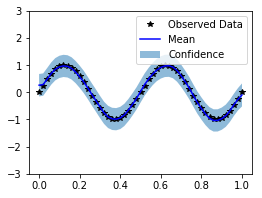

In [17]:
model.eval()
likelihood.eval()

test_x = torch.autograd.Variable(torch.linspace(0, 1, 51))
test_y = torch.sin(test_x * (4 * math.pi))
with gpytorch.settings.max_cg_iterations(2000), gpytorch.settings.use_toeplitz(False), gpytorch.beta_features.diagonal_correction():
    observed_pred = likelihood(model(test_x))

lower, upper = observed_pred.confidence_region()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(test_x.cpu().numpy(), test_y.cpu().numpy(), 'k*')
ax.plot(test_x.data.cpu().numpy(), observed_pred.mean().data.cpu().numpy(), 'b')
ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

print(torch.abs(observed_pred.mean() - test_y)[1:].mean())

In [8]:
observed_pred.mean()

tensor([ 0.2601,  0.2821,  0.4847,  0.6909,  0.8480,  0.9338,  0.9695,
         0.9532,  0.8785,  0.7430,  0.5709,  0.3812,  0.1573, -0.0799,
        -0.3038, -0.5374, -0.7552, -0.9069, -0.9795, -0.9915, -0.9457,
        -0.8344, -0.6578, -0.4494, -0.2281,  0.0287,  0.2817,  0.4904,
         0.6704,  0.8170,  0.9149,  0.9687,  0.9760,  0.9242,  0.7972,
         0.6076,  0.3895,  0.1538, -0.1166, -0.3782, -0.5973, -0.7988,
        -0.9568, -1.0364, -1.0353, -0.9724, -0.8643, -0.6859, -0.4613,
        -0.2584, -0.0987])

In [10]:
test_y

tensor([ 0.0000,  0.2487,  0.4818,  0.6845,  0.8443,  0.9511,  0.9980,
         0.9823,  0.9048,  0.7705,  0.5878,  0.3681,  0.1253, -0.1253,
        -0.3681, -0.5878, -0.7705, -0.9048, -0.9823, -0.9980, -0.9511,
        -0.8443, -0.6845, -0.4818, -0.2487,  0.0000,  0.2487,  0.4818,
         0.6845,  0.8443,  0.9511,  0.9980,  0.9823,  0.9048,  0.7705,
         0.5878,  0.3681,  0.1253, -0.1253, -0.3681, -0.5878, -0.7705,
        -0.9048, -0.9823, -0.9980, -0.9511, -0.8443, -0.6845, -0.4818,
        -0.2487,  0.0000])

In [13]:
torch.abs(observed_pred.mean() - test_y)

tensor([ 0.2601,  0.0334,  0.0029,  0.0063,  0.0037,  0.0173,  0.0285,
         0.0290,  0.0263,  0.0275,  0.0169,  0.0131,  0.0319,  0.0454,
         0.0643,  0.0504,  0.0153,  0.0020,  0.0028,  0.0066,  0.0054,
         0.0099,  0.0267,  0.0323,  0.0206,  0.0287,  0.0330,  0.0087,
         0.0141,  0.0273,  0.0361,  0.0293,  0.0063,  0.0194,  0.0267,
         0.0199,  0.0214,  0.0285,  0.0088,  0.0101,  0.0095,  0.0283,
         0.0519,  0.0541,  0.0372,  0.0213,  0.0199,  0.0013,  0.0205,
         0.0097,  0.0987])

In [18]:
test_x

tensor([ 0.0000,  0.0200,  0.0400,  0.0600,  0.0800,  0.1000,  0.1200,
         0.1400,  0.1600,  0.1800,  0.2000,  0.2200,  0.2400,  0.2600,
         0.2800,  0.3000,  0.3200,  0.3400,  0.3600,  0.3800,  0.4000,
         0.4200,  0.4400,  0.4600,  0.4800,  0.5000,  0.5200,  0.5400,
         0.5600,  0.5800,  0.6000,  0.6200,  0.6400,  0.6600,  0.6800,
         0.7000,  0.7200,  0.7400,  0.7600,  0.7800,  0.8000,  0.8200,
         0.8400,  0.8600,  0.8800,  0.9000,  0.9200,  0.9400,  0.9600,
         0.9800,  1.0000])